In [85]:
import rasterio
import numpy as np
import matplotlib.pyplot as plt
import fiona
from rasterio.warp import reproject, Resampling
from rasterio.mask import mask
%matplotlib inline

In [86]:
# Use Rasterio to open each DEM

src_2012 = rasterio.open('/home/cparr/surfaces/level_1_surfaces/hv/bare_earth/hv_2012_158_bare_earth_dem.tif')
src_2017 = rasterio.open('/home/cparr/surfaces/level_1_surfaces/hv/bare_earth/June4_2017_HappyValley.tif')

In [87]:
# Examine and store the metadata for each DEM

meta12 = src_2012.meta
meta17 = src_2017.meta
print (meta12)
print (meta17)

{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -9999.0, 'width': 1170, 'height': 5680, 'count': 1, 'crs': CRS({'init': 'epsg:32606'}), 'transform': Affine(2.0, 0.0, 421845.91598701477,
       0.0, -2.0, 7673711.170227051)}
{'driver': 'GTiff', 'dtype': 'float32', 'nodata': -32767.0, 'width': 34812, 'height': 104264, 'count': 1, 'crs': CRS({'init': 'epsg:32606'}), 'transform': Affine(0.25, 0.0, 418305.0,
       0.0, -0.25, 7683514.0)}


There are some differences in these data. We'll need to do several things:


<li> Crop the 2017 DEM (larger swath) to the 2012 DEM extent (smaller swath)
<li> Establish common 'NoData' values
<li> Read each DEM to a Numpy Array
<li> Upsample the 2012 DEM from 2 m resolution to 1 m resolution.
<li> Downsample the 2017 DEM from 0.25 m resolution to 1 m resolution.
<li> Subtract the 2012 DEM from the 2017 DEM.
<li> Upsample the 2012 DEM from 2 m resolution to 1 m resolution.
<li> Upsample the 2012 DEM from 2 m resolution to 1 m resolution.
<li> We want to correct for remnant snow in drifts in the 2017 DEM. These should have relatively large positive values in the DEM difference map. Establish a threshold to mask out everything else.
<li> Remove edge artifcats where 2012 outline is nested inside the 2017 DEM These generally have pretty high (e.g. > 1 m) difference values.
<li> Adjust the 2017 DEM by subtracting the correction values (from the drift areas only).
<li> Write the corrected DEM to disk.


Essentially we have a DEM that uses the 2017 surface heights except in the primary drift areas. In the primary drift areas, the 2012 DEM surface heights are used. We may be under-correcting, meaning that the snow patches in the 2017 ortho actually cover more pixels than we are accounting for in the drift mask. However, the threshold we use to determine drift and not drift is tradeoff between snow patch coverage and 'noise' where there are discrepancies between the DEMs related to overlap or some other artefact. Also, no doubt some of the snow covered pixels in 2017 ortho are only covered by a few cm of snow which is really outside the accuracy of our methods anyway.


In [88]:
# Crop the 2017 data to the 2012 data

with fiona.open("/home/cparr/surfaces/level_1_surfaces/hv/bare_earth/hv_2012_158_clipper.shp", "r") as shapefile:
    geoms = [feature["geometry"] for feature in shapefile]

out_image, out_transform = mask(src_2017, geoms, crop=True)
out_meta = src_2017.meta.copy()

out_meta.update({"driver": "GTiff",
                 "height": out_image.shape[1],
                 "width": out_image.shape[2],
                 "transform": out_transform})

# Replace -32767 NoData value with -9999 to match the 2012 data

out_image.data[out_image.data == -32767] = -9999
out_meta.update({"nodata": -9999})

# Write the cropped version out to a new raster

with rasterio.open("/home/cparr/surfaces/level_1_surfaces/hv/bare_earth/hv17cropto12.tif", "w", **out_meta) as dest:
    dest.write(out_image)

In [89]:
# Read the cropped version back in

src_2017 = rasterio.open('/home/cparr/surfaces/level_1_surfaces/hv/bare_earth/hv17cropto12.tif')
src_2017.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 45441,
 'nodata': -9999.0,
 'transform': Affine(0.25, 0.0, 421845.75,
       0.0, -0.25, 7673711.25),
 'width': 9361}

In [90]:
# Read each DEM to a numpy array

dem_2012 = src_2012.read(1)
dem_2017 = src_2017.read(1)

In [91]:
# Upsample the 2012 data to 1 m

new_2012_arr = np.empty(shape=(
                         round(dem_2012.shape[0] / 0.5),
                         round(dem_2012.shape[1] / 0.5)))

aff12 = src_2012.transform
newaff12 = rasterio.Affine(aff12.a * 0.5, aff12.b, aff12.c,
               aff12.d, aff12.e * 0.5, aff12.f)
                     
reproject(
    dem_2012, new_2012_arr,
    src_transform = aff12,
    dst_transform = newaff12,
    src_crs = src_2012.crs,
    dst_crs = src_2012.crs,
    resample = Resampling.bilinear)

print (dem_2012.shape, dem_2012.size)
print (new_2012_arr.shape, new_2012_arr.size)

# Downsample the 2017 data to 1 m 

new_2017_arr = np.empty(shape=(
                            round(dem_2017.shape[0] * 0.25),
                            round(dem_2017.shape[1] * 0.25)))
aff17 = src_2017.transform
newaff17 = rasterio.Affine(aff17.a / 0.25, aff17.b, aff17.c,
                          aff17.d, aff17.e / 0.25, aff17.f)
reproject(
    dem_2017, new_2017_arr,
    src_transform = aff17,
    dst_transform = newaff17,
    src_crs = src_2017.crs,
    dst_crs = src_2017.crs,
    resample = Resampling.bilinear)

print (dem_2017.shape, dem_2017.size)
print (new_2017_arr.shape, new_2017_arr.size)


(5680, 1170) 6645600
(11360, 2340) 26582400
(45441, 9361) 425373201
(11360, 2340) 26582400


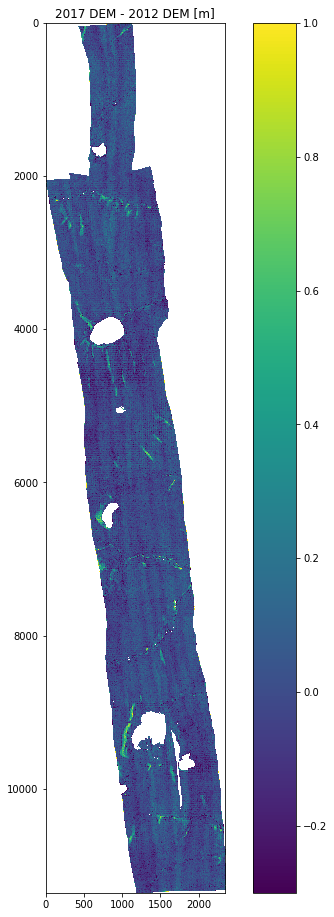

In [96]:
# Set -9999 to NaN for new DEMs so we aren't doing arithmetic with big negative numbers.

new_2012_arr[new_2012_arr == -9999] = np.nan
new_2017_arr[new_2017_arr == -9999] = np.nan

# Create a 2017 - 2012 DEM difference map

dem_diff = new_2017_arr - new_2012_arr

# Turning nan values to zeroes.
dem_diff_w_nd_eq_zero = np.nan_to_num(dem_diff)

plt.figure(figsize = (10,16))
plt.imshow(dem_diff,vmin=-0.3,vmax=1)
plt.title("2017 DEM - 2012 DEM [m]")
plt.colorbar()


0.219720025797


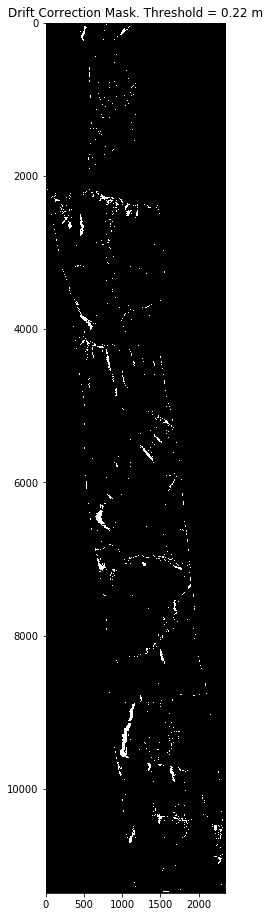

In [101]:
# Use a threshold of difference to isolate drifts where we want to make adjustments

threshold = np.nanmean(dem_diff) + np.nanstd(dem_diff)
print (threshold * 1.5)
drifts = dem_diff_w_nd_eq_zero > threshold * 1.5

plt.figure(figsize = (10,16))
plt.imshow(drifts, cmap='gray')
plt.title("Drift Correction Mask. Threshold = %.2f m" % (threshold*1.5))

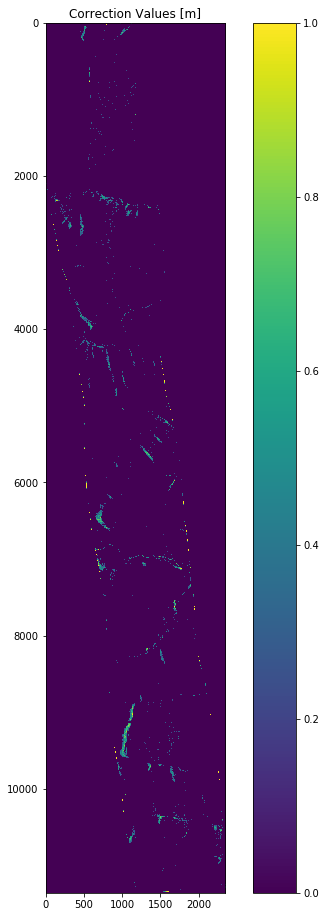

In [103]:
# We know where the corrections should go
# Now get the corrections in those areas

drift_correction_values = drifts * dem_diff_w_nd_eq_zero
plt.figure(figsize = (10,16))
plt.imshow(drift_correction_values,vmin=0,vmax=1)
plt.title('Correction Values [m]')
plt.colorbar()

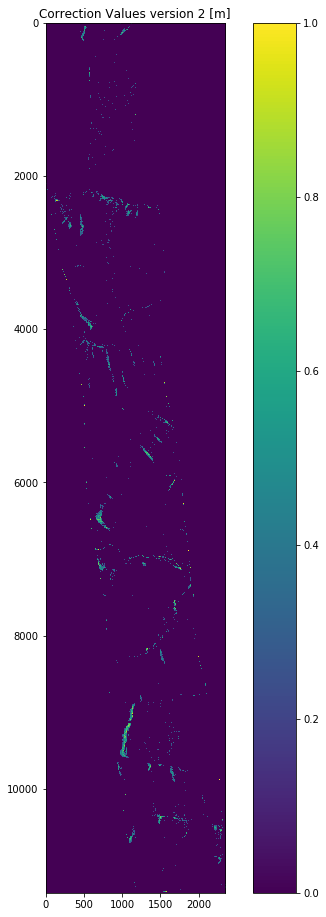

In [105]:
# But the bright yellow around the edges could introduce weird artifacts...
# We can try to remove those

drift_correction_values[drift_correction_values > 1] = 0
plt.figure(figsize = (10,16))
plt.imshow(drift_correction_values, vmin=0, vmax=1)
plt.title('Correction Values version 2 [m]')
plt.colorbar()

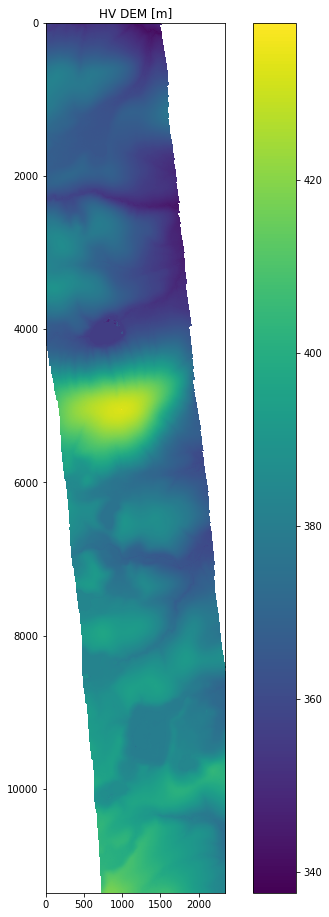

In [106]:
# Now apply corrections by subtracting the correction values from the 2017 DEM.

hv_dem_corrected = new_2017_arr - drift_correction_values
hv_final = hv_dem_corrected.astype('float32')

plt.figure(figsize = (10,16))
plt.imshow(hv_final)
plt.title('HV DEM [m]')
plt.colorbar()

In [107]:
# Write the corrected DEM to Disk

out_meta = src_2017.meta.copy()

out_meta.update({"height": hv_dem_corrected.shape[0],
                 "width": hv_dem_corrected.shape[1],
                 "transform": newaff17,
                 "nodata": np.nan})


with rasterio.open("/home/cparr/surfaces/level_1_surfaces/hv/bare_earth/hv_dem_final.tif", "w", **out_meta) as dest:
    dest.write(hv_final,1)

In [111]:
# Read it back in, check metadata, plot

src = rasterio.open("/home/cparr/surfaces/level_1_surfaces/hv/bare_earth/hv_dem_final.tif")
src.meta

{'count': 1,
 'crs': CRS({'init': 'epsg:32606'}),
 'driver': 'GTiff',
 'dtype': 'float32',
 'height': 11360,
 'nodata': nan,
 'transform': Affine(1.0, 0.0, 421845.75,
       0.0, -1.0, 7673711.25),
 'width': 2340}

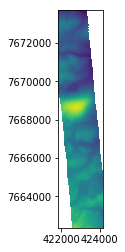

In [112]:
from rasterio.plot import show
show(src)

In [108]:
del src_2012
del src_2017
del dem_2012
del dem_2017
del new_2012_arr
del new_2017_arr